In [1]:
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
B = 7
c = .1
sigma_mu=sigma- np.diag(mu)
A= sigma_mu+np.diag([-2*B*c for i in range(num_assets)])+c*np.ones((num_assets,num_assets))

In [3]:
def cost(x):
    return x.dot(A).dot(x)
from qiskit.quantum_info import SparsePauliOp

def indexedZ(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'Z' + 'I'*(i))

def indexedY(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'Y' + 'I'*(i))

def indexedX(i):
    return SparsePauliOp((num_assets-i-1)*'I' + 'X' + 'I'*(i))

In [4]:
from qiskit import QuantumCircuit
from functools import reduce
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
H = 0 * SparsePauliOp('I' * num_assets)
for i in range(num_assets):
    for j in range(num_assets):
        H+=1/4 * A[i][j]* SparsePauliOp('I' * num_assets)-1/2 *  A[i][j]* indexedZ(i)+1/4 * A[i][j] * indexedZ(i) @ indexedZ(j)
H=H.simplify()


H_mix = reduce(lambda a,b: a+b, [indexedX(i) for i in range(num_assets)])
default_mixer = QuantumCircuit(num_assets)
default_mixer.append( PauliEvolutionGate(H_mix, Parameter('t')), range(num_assets))


In [5]:
from qiskit.circuit import ParameterVector
def QAOA_Ansatz(cost,mixer,p=1,initial=None):
    qc=QuantumCircuit(num_assets)
    if(initial is None):
        qc.h(range(num_assets))
    else:
        qc = initial.copy()
    Gamma = ParameterVector('γ',p)
    Beta = ParameterVector('β',p)
    for i in range(p):
        qc.append(PauliEvolutionGate(cost,Gamma[i]),range(num_assets))
        qc.append(mixer.assign_parameters([Beta[i]]),range(num_assets))
    return qc


In [6]:
import cvxpy as cp
from scipy.linalg import sqrtm
def GWcut(reps=1):
    min = None
    min_x = None

    X=cp.Variable((num_assets,num_assets),PSD=True)
    constraints = [X >> 0]
    constraints += [
        X[i,i] == 1 for i in range(num_assets)
    ]
    objective = cp.trace(-A @ X)
    prob = cp.Problem(cp.Maximize(objective),constraints)
    prob.solve()
    x=sqrtm(X.value)
    
    for i in range(reps):

        u = np.random.random(num_assets)
        z=np.array(np.sign(x.real @ u)/2+1/2,dtype=int)
        l=cost(z)
        if(i==0):
            min = l
            min_x = z
        else:
            if(l<min):
                min = l
                min_x = z
    return (min,min_x)

In [7]:
epsilon=0.25
def WarmStartQAOA(initial,cost,p=1,modified=True):
    
    theta = [2*np.arcsin(np.sqrt(1-epsilon)),2*np.arcsin(np.sqrt(epsilon))]

    init_qc= QuantumCircuit(num_assets)
    mixer=QuantumCircuit(num_assets)

    t = Parameter('t')
    for i,v in enumerate(initial):
        init_qc.ry(theta[v],i)
        if(modified):
            mixer.ry(theta[v],i)
            mixer.rz(-2*t,i)
            mixer.ry(-theta[v],i)
        else:
            mixer.ry(-theta[v],i)
            mixer.rz(-2*t,i)
            mixer.ry(theta[v],i)
    return QAOA_Ansatz(cost=cost,mixer=mixer,p=p,initial=init_qc)



In [8]:
initial = (GWcut(100)[1])
qaoa_ansatz = QAOA_Ansatz(H,default_mixer,p=1)
modified_wsqaoa_ansatz = WarmStartQAOA(initial,H,p=1,modified=True)
wsqaoa_ansatz = WarmStartQAOA(initial,H,p=1,modified=False) 

In [9]:
qaoa_data = np.zeros((50,50))
wsqaoa_data = np.zeros((50,50))
modified_wsqaoa_data= np.zeros((50,50))

In [10]:
from qiskit.quantum_info import Statevector
for i,x in enumerate(np.linspace(0,2*np.pi,50)):
    for j,y in enumerate(np.linspace(0,2*np.pi,50)):
        qaoa_data[i][j]=Statevector(qaoa_ansatz.assign_parameters([x,y])).expectation_value(H).real
        wsqaoa_data[i][j]=Statevector(wsqaoa_ansatz.assign_parameters([x,y])).expectation_value(H).real
        modified_wsqaoa_data[i][j]=Statevector(modified_wsqaoa_ansatz.assign_parameters([x,y])).expectation_value(H).real


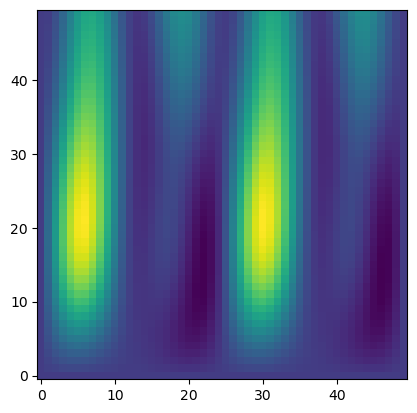

In [11]:
import matplotlib.pyplot as plt
plt.imshow(qaoa_data.T,origin='lower')

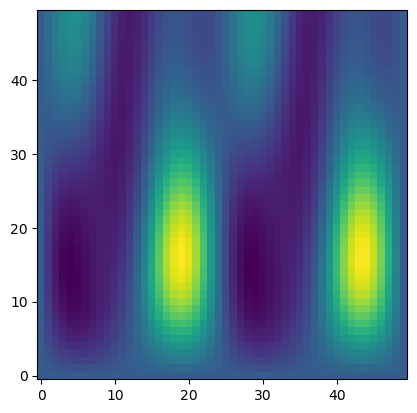

In [12]:
plt.imshow(wsqaoa_data.T,origin='lower')

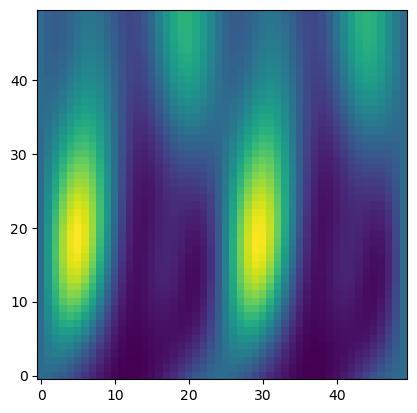

In [13]:
plt.imshow(modified_wsqaoa_data.T,origin='lower')

In [14]:
np.min(qaoa_data)

-4.799663793833991

In [15]:
np.min(wsqaoa_data)

-4.760879558601513

In [16]:
np.min(modified_wsqaoa_data)

-4.858685609620228

In [17]:
initial = (GWcut(100)[1])
cost(initial)

-4.859411435366528

In [18]:
p_max = 8
initial = (GWcut(100)[1])
defualt_qaoa_ansatze = [QAOA_Ansatz(H,default_mixer,p=p) for p in range(1,p_max)]
modified_wsqaoa_ansatze = [WarmStartQAOA(initial,H,p=p,modified=True) for p in range(1,p_max)]
wsqaoa_ansatze = [WarmStartQAOA(initial,H,p=p,modified=False) for p in range(1,p_max)]

from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector

In [19]:
from qiskit_algorithms.optimizers import COBYLA,SPSA
opt = SPSA(maxiter=1000)
def minimize(ansatz_list,reps=5):
    print("Starting Optimization")
    print("---------------------")
    cost_list = []
    parameter_list = []
    for n,a in enumerate(ansatz_list):
        current_cost = []
        current_params = []
        for i in range(reps):
            # if(n==0):
            #     #init = np.random.random(2)*2*np.pi
            # else:
            #     #init = np.array(list(parameter_list[-1])+[0,0])
            res = opt.minimize(lambda x: Statevector(a.assign_parameters(x)).expectation_value(H).real, x0=np.random.random(2*(n+1))*2*np.pi )
            if(i==0):
                current_cost = res.fun
                current_params =res.x
            elif(current_cost > res.fun):
                current_cost = res.fun
                current_params =res.x
        cost_list.append(current_cost)
        parameter_list.append(current_params)
        print(n)
    return cost_list,parameter_list
                
                

In [20]:
defualt_res=minimize(defualt_qaoa_ansatze)
modified_ws_res = minimize(modified_wsqaoa_ansatze)
ws_res=minimize(wsqaoa_ansatze)

Starting Optimization
---------------------
0


KeyboardInterrupt: 

In [ ]:
plt.plot(defualt_res[0],label='default')
plt.plot(modified_ws_res[0],label='modws')
plt.plot(ws_res[0],label='ws')
plt.legend()
plt.plot(np.vstack([np.linalg.eigvalsh(H)[0].real for i in range(1,p_max)]))